![image info](https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/images/banner_1.png)

# Proyecto 1 - Predicción de precios de vehículos usados

En este proyecto podrán poner en práctica sus conocimientos sobre modelos predictivos basados en árboles y ensambles, y sobre la disponibilización de modelos. Para su desasrrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 1: Predicción de precios de vehículos usados".

**Entrega**: La entrega del proyecto deberán realizarla durante la semana 4. Sin embargo, es importante que avancen en la semana 3 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 4, y subir el archivo de predicciones a la [competencia de Kaggle](https://www.kaggle.com/t/b8be43cf89c540bfaf3831f2c8506614).

## Datos para la predicción de precios de vehículos usados

En este proyecto se usará el conjunto de datos de Car Listings de Kaggle, donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como: año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

## Ejemplo predicción conjunto de test para envío a Kaggle

En esta sección encontrarán el formato en el que deben guardar los resultados de la predicción para que puedan subirlos a la competencia en Kaggle.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación librerías
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

In [3]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/dataTrain_carListings.zip')
dataTesting = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/dataTest_carListings.zip', index_col=0)


11


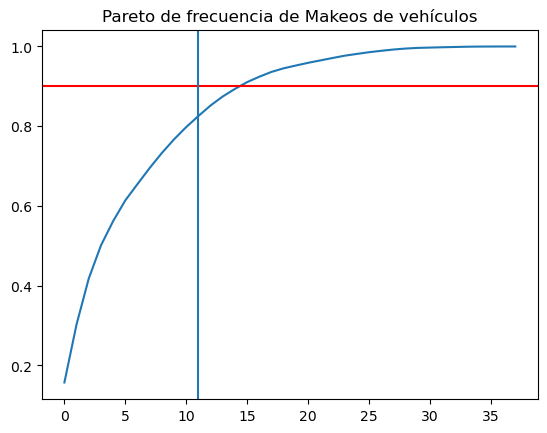

In [4]:
plt.plot(np.cumsum(dataTraining.value_counts('Make',normalize=True)).to_numpy())

Umbral = np.sum(np.cumsum(dataTraining.value_counts('Make',normalize=True)).to_numpy() < 0.8)
plt.axhline(y=0.9, color='r')
plt.axvline(x=Umbral)
print(Umbral)
plt.title('Pareto de frecuencia de Makeos de vehículos')
plt.show()

In [127]:
Info_Make_models= dataTraining.apply(lambda x: x['Make']+x['Model'], axis=1).drop_duplicates().tolist()
Frecuencia_Acumulada = dataTraining[['Make','Model']].value_counts(normalize=True).reset_index().sort_values(0,ascending=False)
Frecuencia_Acumulada['Porcentaje Acum'] = Frecuencia_Acumulada[0].cumsum()
Particiones = [0.2,0.4,0.6,0.8,0.9,0.95,0.985,1]
Particiones_Marcas = {}
for i in Particiones:
    Particiones_Marcas[i]= Frecuencia_Acumulada[Frecuencia_Acumulada['Porcentaje Acum']<i][['Make','Model']]
    Frecuencia_Acumulada = Frecuencia_Acumulada[Frecuencia_Acumulada['Porcentaje Acum']>=i]

In [235]:
df_models = {}
suma=0
for i in Particiones:
    df_aux=pd.merge(Particiones_Marcas[i],dataTraining,on=['Make','Model'])
    df_aux['Make-Mod'] = df_aux.apply(lambda x: x['Make']+x['Model'], axis=1)
    df_aux=df_aux.drop(columns=['Make','Model'],axis=1)
    df_models[i]=df_aux
    print('La cantidad de registros de la partición ' + str(i) + ' es ' + str(df_aux.shape))
    suma += df_aux.shape[0]
    print('Cantidad total de registros: ' +str (suma))
df_models[0.2].head(5)


La cantidad de registros de la partición 0.2 es (75791, 5)
Cantidad total de registros: 75791
La cantidad de registros de la partición 0.4 es (82112, 5)
Cantidad total de registros: 157903
La cantidad de registros de la partición 0.6 es (81685, 5)
Cantidad total de registros: 239588
La cantidad de registros de la partición 0.8 es (80360, 5)
Cantidad total de registros: 319948
La cantidad de registros de la partición 0.9 es (39855, 5)
Cantidad total de registros: 359803
La cantidad de registros de la partición 0.95 es (20051, 5)
Cantidad total de registros: 379854
La cantidad de registros de la partición 0.985 es (14068, 5)
Cantidad total de registros: 393922
La cantidad de registros de la partición 1 es (6078, 5)
Cantidad total de registros: 400000


,Price,Year,Mileage,State,Make-Mod
0,36400,2014,28234,NJ,ChevroletSilverado
1,30478,2015,43786,TX,ChevroletSilverado
2,27410,2014,41994,GA,ChevroletSilverado
3,13000,2008,142000,IA,ChevroletSilverado
4,25981,2012,89094,AL,ChevroletSilverado


In [236]:
#Escalado de variables
df_scaled = {}
scalers ={}
valores_maximos= {}
valores_minimos = {}
Variable_y = ['Price']
Variables_numericas=['Year','Mileage']
Variables_categoricas= ['State','Make-Mod']
for i in Particiones:
    df_model_nums = df_models[i][Variables_numericas]
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df_model_nums)
    scalers[i]= scaler
    scaled_data = pd.DataFrame(scaled_data,columns=['Year','Mileage'])
    valores_maximos[i]=scaled_data.max().tolist()
    valores_minimos[i]=scaled_data.min().tolist()

    df_scaled[i]=pd.concat([df_models[i][Variable_y+Variables_categoricas],scaled_data],axis=1)
df_scaled[0.2].head()

,Price,State,Make-Mod,Year,Mileage
0,36400,NJ,ChevroletSilverado,0.220138,-0.589926
1,30478,TX,ChevroletSilverado,0.552883,-0.223405
2,27410,GA,ChevroletSilverado,0.220138,-0.265638
3,13000,IA,ChevroletSilverado,-1.776332,2.091245
4,25981,AL,ChevroletSilverado,-0.445352,0.844387


In [8]:
#Codificación One-Hot
df_dummies = {}
for i in Particiones:
    df_dummies[i]=pd.get_dummies(df_scaled[i],columns=Variables_categoricas)
    print('La partición ' + str(i) + ' tiene la siguiente forma: ' + str(df_dummies[i].shape))
df_dummies[0.2]

La partición 0.2 tiene la siguiente forma: (75791, 64)
La partición 0.4 tiene la siguiente forma: (82112, 80)
La partición 0.6 tiene la siguiente forma: (81685, 105)
La partición 0.8 tiene la siguiente forma: (80360, 147)
La partición 0.9 tiene la siguiente forma: (39855, 145)
La partición 0.95 tiene la siguiente forma: (20051, 130)
La partición 0.985 tiene la siguiente forma: (14068, 151)
La partición 1 tiene la siguiente forma: (6078, 142)


,Price,Year,Mileage,State_ AK,State_ AL,State_ AR,State_ AZ,State_ CA,State_ CO,State_ CT,...,Make-Mod_BMW3,Make-Mod_ChevroletSilverado,Make-Mod_FordF-1504WD,Make-Mod_FordFusionSE,Make-Mod_GMCSierra,Make-Mod_HondaAccord,Make-Mod_HondaCivic,Make-Mod_JeepGrand,Make-Mod_JeepWrangler,Make-Mod_VolkswagenJetta
0,36400,0.220138,-0.589926,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,30478,0.552883,-0.223405,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,27410,0.220138,-0.265638,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,13000,-1.776332,2.091245,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,25981,-0.445352,0.844387,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75786,17324,0.885628,-0.364456,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
75787,15500,0.220138,-0.342680,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
75788,16979,0.885628,-0.814382,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
75789,16998,0.220138,-0.629920,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [9]:
#Separación Variables predictoras y a predecir.
df_transf = {}
for i in Particiones:
    TipoVariable = {}
    TipoVariable['X']=df_dummies[i].drop('Price',axis=1)
    TipoVariable['y']=df_dummies[i]['Price']
    df_transf[i]=TipoVariable
df_transf[0.2]['y']

0        36400
1        30478
2        27410
3        13000
4        25981
         ...  
75786    17324
75787    15500
75788    16979
75789    16998
75790    14500
Name: Price, Length: 75791, dtype: int64

#### Entrenamiento de modelos

In [10]:
#Cálculo de métricas
def Metricas(yTesteo,y_pred):
    mse_metric = round(mean_squared_error(yTesteo, y_pred),2)
    r2_metric = round(r2_score(yTesteo, y_pred),3)
    mae_metric = round(mean_absolute_error(yTesteo, y_pred),2)
    print("Desempeño del modelo:")
    print("Mean Squared Error:", mse_metric)
    print("R^2 Score:", r2_metric)
    print("Mean Absolute Error (MAE):", mae_metric)
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mape_metric = round(mean_absolute_percentage_error(yTesteo, y_pred),2)
    print("Mean Absolute Percentage Error (MAPE):", mape_metric, "%")
    print(' ')
    return [r2_metric,mse_metric,mae_metric,mape_metric]

##### XGBoost sin calibrar

In [294]:
#Entrenamiento de modelos
Xgboost_predictores = {}
Xgboost_metricas = {}
s=0
yTest_Completo = np.array([])
yPred_Completo = np.array([])
for i in Particiones:
    s+=1
    XTrain, XTest, yTrain, yTest = train_test_split(df_transf[i]['X'], df_transf[i]['y'], test_size=0.3, random_state=0)
    Xgboost_predictores[i] = XGBRegressor(random_state=0,n_estimators = 100,learning_rate=0.3,max_depth=6).fit(XTrain,yTrain)
    print('Modelo de partición ' + str(i) + ' Progreso: ' + str(round(s/len(Particiones)*100,0)) + '%')
    print('Dim Xtrain: ' + str(XTrain.shape)+ 'Dim Xtrain: ' + str(yTrain.shape)+ 'Dim Xtrain: ' + str(XTest.shape)+ 'Dim Xtrain: ' + str(yTest.shape))
    
    yPred = Xgboost_predictores[i].predict(XTest)
    yTest_Completo = np.concatenate((yTest_Completo,yTest.to_numpy()))
    yPred_Completo = np.concatenate((yPred_Completo,yPred))
    print('Resultados: ')
    Xgboost_metricas[i]=Metricas(yTest,yPred)
    #Desempeño modelo: 
print('Resultados finales Concatenados:')
Xgboost_metricas_Total = Metricas(yTest_Completo,yPred_Completo)

Modelo de partición 0.2 Progreso: 12.0%
Dim Xtrain: (53053, 63)Dim Xtrain: (53053,)Dim Xtrain: (22738, 63)Dim Xtrain: (22738,)
Resultados: 
Desempeño del modelo:
Mean Squared Error: 25579437.79
R^2 Score: 0.797
Mean Absolute Error (MAE): 3359.17
Mean Absolute Percentage Error (MAPE): 14.07 %
 
Modelo de partición 0.4 Progreso: 25.0%
Dim Xtrain: (57478, 79)Dim Xtrain: (57478,)Dim Xtrain: (24634, 79)Dim Xtrain: (24634,)
Resultados: 
Desempeño del modelo:
Mean Squared Error: 13785692.73
R^2 Score: 0.847
Mean Absolute Error (MAE): 2215.9
Mean Absolute Percentage Error (MAPE): 10.98 %
 
Modelo de partición 0.6 Progreso: 38.0%
Dim Xtrain: (57179, 104)Dim Xtrain: (57179,)Dim Xtrain: (24506, 104)Dim Xtrain: (24506,)
Resultados: 
Desempeño del modelo:
Mean Squared Error: 7424379.68
R^2 Score: 0.935
Mean Absolute Error (MAE): 1886.27
Mean Absolute Percentage Error (MAPE): 9.35 %
 
Modelo de partición 0.8 Progreso: 50.0%
Dim Xtrain: (56252, 146)Dim Xtrain: (56252,)Dim Xtrain: (24108, 146)Dim Xtra

In [12]:
#Evuación de particiones
pd.DataFrame(Xgboost_metricas).T.rename(columns={0:'R2',1:'MSE',2:'MAE',3:'MAPE'})

,R2,MSE,MAE,MAPE
0.200,0.797,25579437.79,3359.17,14.07
0.400,0.847,13785692.73,2215.90,10.98
0.600,0.935,7424379.68,1886.27,9.35
0.800,0.922,7871625.92,1936.51,10.31
0.900,0.946,6612486.77,1780.10,9.80
0.950,0.933,7838905.14,1781.21,11.22
0.985,0.949,8353582.20,1925.88,12.48
1.000,0.954,8289022.85,1850.74,12.53


##### Random Forest

In [13]:
#Entrenamiento de modelos
rf_predictores = {}
rf_metricas = {}
s=0
yTest_Completo = np.array([])
yPred_Completo = np.array([])
for i in Particiones:
    s+=1
    XTrain, XTest, yTrain, yTest = train_test_split(df_transf[i]['X'], df_transf[i]['y'], test_size=0.3, random_state=0)
    rf_predictores[i] = RandomForestRegressor(random_state=0).fit(XTrain,yTrain)
    print('Modelo de partición ' + str(i) + ' Progreso: ' + str(round(s/len(Particiones)*100,0)) + '%')
    print('Dim Xtrain: ' + str(XTrain.shape)+ 'Dim Xtrain: ' + str(yTrain.shape)+ 'Dim Xtrain: ' + str(XTest.shape)+ 'Dim Xtrain: ' + str(yTest.shape))
    
    yPred = rf_predictores[i].predict(XTest)
    yTest_Completo = np.concatenate((yTest_Completo,yTest.to_numpy()))
    yPred_Completo = np.concatenate((yPred_Completo,yPred))
    print('Resultados: ')
    rf_metricas[i]=Metricas(yTest,yPred)
    #Desempeño modelo: 
print('Resultados finales Concatenados:')
Random_Forest_metricas_Total= Metricas(yTest_Completo,yPred_Completo)

Modelo de partición 0.2 Progreso: 12.0%
Dim Xtrain: (53053, 63)Dim Xtrain: (53053,)Dim Xtrain: (22738, 63)Dim Xtrain: (22738,)
Resultados: 
Desempeño del modelo:
Mean Squared Error: 30371653.16
R^2 Score: 0.759
Mean Absolute Error (MAE): 3635.92
Mean Absolute Percentage Error (MAPE): 15.06 %
 
Modelo de partición 0.4 Progreso: 25.0%
Dim Xtrain: (57478, 79)Dim Xtrain: (57478,)Dim Xtrain: (24634, 79)Dim Xtrain: (24634,)
Resultados: 
Desempeño del modelo:
Mean Squared Error: 15996269.21
R^2 Score: 0.823
Mean Absolute Error (MAE): 2338.14
Mean Absolute Percentage Error (MAPE): 11.46 %
 
Modelo de partición 0.6 Progreso: 38.0%
Dim Xtrain: (57179, 104)Dim Xtrain: (57179,)Dim Xtrain: (24506, 104)Dim Xtrain: (24506,)
Resultados: 
Desempeño del modelo:
Mean Squared Error: 8345278.19
R^2 Score: 0.927
Mean Absolute Error (MAE): 1957.73
Mean Absolute Percentage Error (MAPE): 9.67 %
 
Modelo de partición 0.8 Progreso: 50.0%
Dim Xtrain: (56252, 146)Dim Xtrain: (56252,)Dim Xtrain: (24108, 146)Dim Xtr

In [14]:
#Evuación de particiones
pd.DataFrame(rf_metricas).T.rename(columns={0:'R2',1:'MSE',2:'MAE',3:'MAPE'})

,R2,MSE,MAE,MAPE
0.200,0.759,30371653.16,3635.92,15.06
0.400,0.823,15996269.21,2338.14,11.46
0.600,0.927,8345278.19,1957.73,9.67
0.800,0.917,8341629.45,1942.88,10.14
0.900,0.943,6985181.27,1785.28,9.67
0.950,0.928,8433603.41,1836.43,11.56
0.985,0.946,8755225.09,1908.61,12.19
1.000,0.951,8780178.61,1870.54,12.74


#### Calibración de modelo

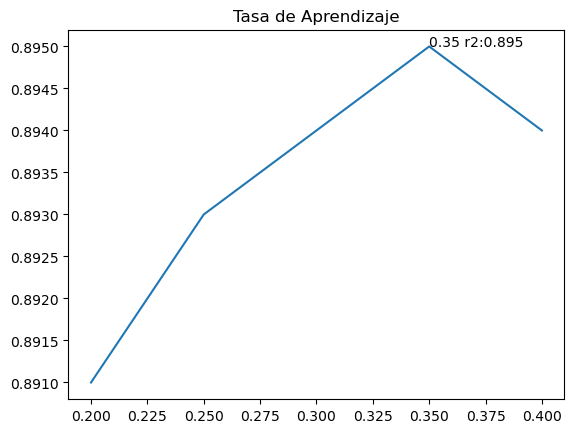

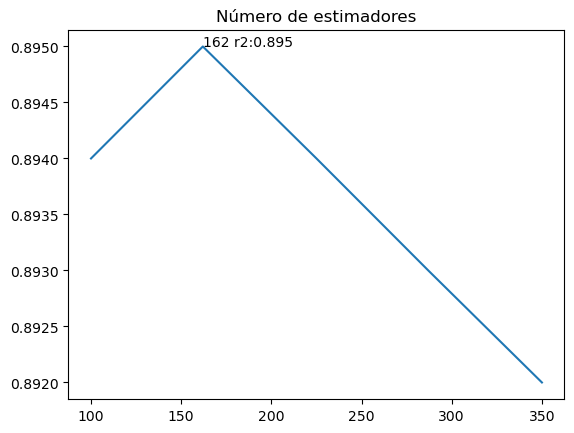

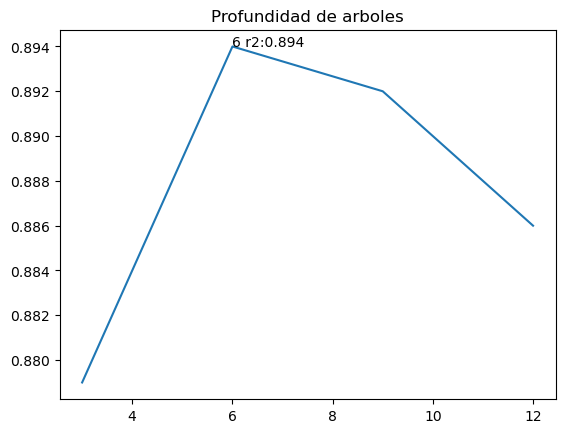

In [15]:
#Calibrando parametros

def Probar_modelo(modelo):
    Xgboost_calibrado_predictores = {}
    Xgboost_calibrado_metricas = {}
    s=0
    yTest_Completo = np.array([])
    yPred_Completo = np.array([])
    for i in Particiones:
        s+=1
        XTrain, XTest, yTrain, yTest = train_test_split(df_transf[i]['X'], df_transf[i]['y'], test_size=0.3, random_state=0)
        Xgboost_calibrado_predictores[i] = modelo.fit(XTrain,yTrain)
        yPred = Xgboost_calibrado_predictores[i].predict(XTest)
        yTest_Completo = np.concatenate((yTest_Completo,yTest.to_numpy()))
        yPred_Completo = np.concatenate((yPred_Completo,yPred)) 
    return round(r2_score(yTest_Completo, yPred_Completo),3)
Probar_modelo(XGBRegressor(random_state=0))

#Calibración de Learning Rate:
learningRate_C = np.linspace(0.2, 0.4, num=5)
r2_learningRate_C = []

for k in learningRate_C:
    r2_learningRate_C.append(Probar_modelo(XGBRegressor(random_state=0,learning_rate=k)))

ymax = max(r2_learningRate_C)
xmax = learningRate_C.tolist()[r2_learningRate_C.index(ymax)]

plt.plot(learningRate_C,r2_learningRate_C)
plt.text(x=xmax,y=ymax, s=str(round(xmax,3))+' r2:' + str(ymax))

plt.title('Tasa de Aprendizaje')
plt.show()

#Calibración de N_Estimator:
n_estimators_C = np.linspace(100, 220, num=4, dtype=int)
r2_n_estimators_C = []
for k in n_estimators_C:
    r2_n_estimators_C.append(Probar_modelo(XGBRegressor(random_state=0,n_estimators=k)))

ymax = max(r2_n_estimators_C)
xmax = n_estimators_C.tolist()[r2_n_estimators_C.index(ymax)]

plt.plot(n_estimators_C,r2_n_estimators_C)
plt.text(x=xmax,y=ymax, s=str(xmax)+' r2:' + str(ymax))
plt.title('Número de estimadores')
plt.show()

#PRofundidad Máxima de arbol
max_depth_C = np.linspace(3, 12, num=4, dtype=int)
r2_max_depth_C = []
for k in max_depth_C:
    r2_max_depth_C.append(Probar_modelo(XGBRegressor(random_state=0,max_depth =k)))

ymax = max(r2_max_depth_C)
xmax = max_depth_C.tolist()[r2_max_depth_C.index(ymax)]

plt.plot(max_depth_C,r2_max_depth_C)
plt.text(x=xmax,y=ymax, s=str(xmax)+' r2:' + str(ymax))
plt.title('Profundidad de arboles')
plt.show()

#### Entrenamineto de modelo Calibrado

In [41]:
#Entrenamiento de modelos
Xgboost_calibrado_predictores = {}
Xgboost_calibrado_metricas = {}
s=0
yTest_Completo = np.array([])
yPred_Completo = np.array([])
for i in Particiones:
    s+=1
    XTrain, XTest, yTrain, yTest = train_test_split(df_transf[i]['X'], df_transf[i]['y'], test_size=0.3, random_state=0)
    Xgboost_calibrado_predictores[i] = XGBRegressor(random_state=0,learning_rate=0.35, max_depth=6,n_estimators=162).fit(XTrain,yTrain)
    print('Modelo de partición ' + str(i) + ' Progreso: ' + str(round(s/len(Particiones)*100,0)) + '%')
    print('Dim Xtrain: ' + str(XTrain.shape)+ 'Dim Xtrain: ' + str(yTrain.shape)+ 'Dim Xtrain: ' + str(XTest.shape)+ 'Dim Xtrain: ' + str(yTest.shape))
    
    yPred = Xgboost_calibrado_predictores[i].predict(XTest)
    yTest_Completo = np.concatenate((yTest_Completo,yTest.to_numpy()))
    yPred_Completo = np.concatenate((yPred_Completo,yPred))
    print('Resultados: ')
    Xgboost_calibrado_metricas[i]=Metricas(yTest,yPred)
    #Desempeño modelo: 
print('Resultados finales Concatenados:')
Xgboost_Calibrado_metricas_Total=Metricas(yTest_Completo,yPred_Completo)

Modelo de partición 0.2 Progreso: 12.0%
Dim Xtrain: (53053, 63)Dim Xtrain: (53053,)Dim Xtrain: (22738, 63)Dim Xtrain: (22738,)
Resultados: 
Desempeño del modelo:
Mean Squared Error: 26081278.67
R^2 Score: 0.793
Mean Absolute Error (MAE): 3385.85
Mean Absolute Percentage Error (MAPE): 14.2 %
 
Modelo de partición 0.4 Progreso: 25.0%
Dim Xtrain: (57478, 79)Dim Xtrain: (57478,)Dim Xtrain: (24634, 79)Dim Xtrain: (24634,)
Resultados: 
Desempeño del modelo:
Mean Squared Error: 13980032.64
R^2 Score: 0.845
Mean Absolute Error (MAE): 2225.83
Mean Absolute Percentage Error (MAPE): 11.04 %
 
Modelo de partición 0.6 Progreso: 38.0%
Dim Xtrain: (57179, 104)Dim Xtrain: (57179,)Dim Xtrain: (24506, 104)Dim Xtrain: (24506,)
Resultados: 
Desempeño del modelo:
Mean Squared Error: 7387203.85
R^2 Score: 0.936
Mean Absolute Error (MAE): 1862.06
Mean Absolute Percentage Error (MAPE): 9.19 %
 
Modelo de partición 0.8 Progreso: 50.0%
Dim Xtrain: (56252, 146)Dim Xtrain: (56252,)Dim Xtrain: (24108, 146)Dim Xtra

In [42]:
pd.DataFrame(Xgboost_calibrado_metricas).T.rename(columns={0:'R2',1:'MSE',2:'MAE',3:'MAPE'})

,R2,MSE,MAE,MAPE
0.200,0.793,26081278.67,3385.85,14.20
0.400,0.845,13980032.64,2225.83,11.04
0.600,0.936,7387203.85,1862.06,9.19
0.800,0.927,7322164.09,1842.66,9.65
0.900,0.949,6302522.86,1697.84,9.20
0.950,0.930,8132584.40,1762.59,10.90
0.985,0.952,7906854.34,1820.83,11.59
1.000,0.955,8083018.96,1786.98,12.11


#### Comparación de modelos

In [298]:

Nombres_Modelos= ['Random_Forest','XGBoost_Sin_Calibrar','XGBoost_Calibrado']

Data_Comparacion = pd.DataFrame([Random_Forest_metricas_Total,Xgboost_metricas_Total,Xgboost_Calibrado_metricas_Total]
             ,index=Nombres_Modelos,columns=['R2','MSE','MAE','MAPE'])
Data_Comparacion

,R2,MSE,MAE,MAPE
Random_Forest,0.879,13978545.35,2324.50,11.38
XGBoost_Sin_Calibrar,0.894,12245733.67,2228.12,11.07
XGBoost_Calibrado,0.894,12227733.58,2197.62,10.83


In [323]:
np.arange(len(Data_Comparacion.columns)-1)

array([0, 1, 2])

In [331]:
for k in np.arange(len(Data_Comparacion.columns)-1):
    print(Data_Comparacion.index.tolist()[k])

Random_Forest
XGBoost_Sin_Calibrar
XGBoost_Calibrado


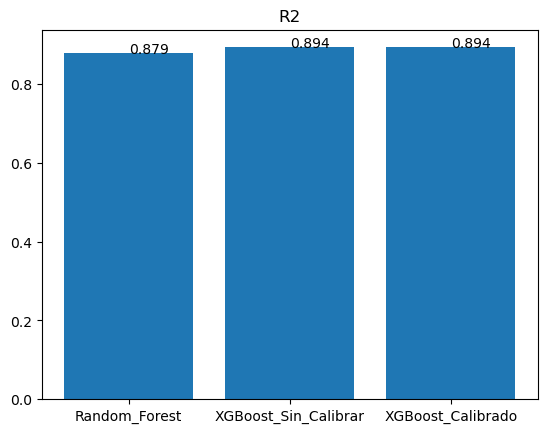

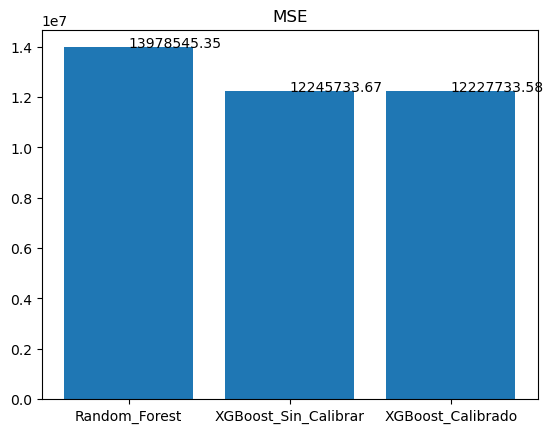

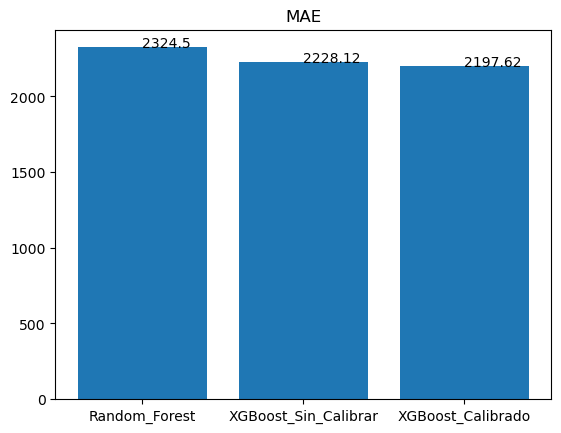

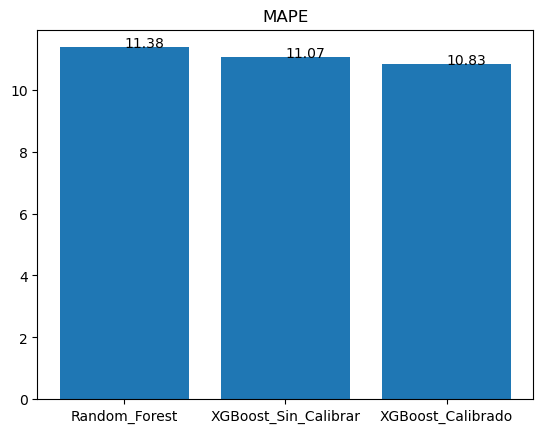

In [333]:
for i in Data_Comparacion.columns:
    plt.bar(x=Data_Comparacion.index,height=Data_Comparacion[i])
    for k in np.arange(len(Data_Comparacion.columns)-1):
        plt.text(x=Data_Comparacion.index.tolist()[k],y=Data_Comparacion[i][k],s=Data_Comparacion[i][k])
    plt.title(i)
    plt.show()

En base a los resultados presentados, podemos hacer las siguientes conclusiones:

R2: El coeficiente de determinación (R2) es un indicador de qué tan bien se ajusta el modelo a los datos. Cuanto más cercano a 1 sea el valor de R2, mejor se ajustará el modelo a los datos. En este caso, los modelos de Random Forest y XGBoost (calibrado y sin calibrar) tienen valores de R2 muy similares, lo que indica que todos los modelos se ajustan bien a los datos.

MSE: El error cuadrático medio (MSE) mide el promedio de los errores al cuadrado de las predicciones del modelo. Cuanto menor sea el valor de MSE, mejor será el modelo. En este caso, el modelo XGBoost calibrado tiene el valor más bajo de MSE, lo que indica que es el mejor modelo en términos de precisión.

MAE: El error absoluto medio (MAE) mide el promedio de los errores absolutos de las predicciones del modelo. Cuanto menor sea el valor de MAE, mejor será el modelo. En este caso, el modelo XGBoost calibrado tiene el valor más bajo de MAE, lo que indica que es el mejor modelo en términos de precisión.

MAPE: El error porcentual absoluto medio (MAPE) mide el promedio de los errores porcentuales de las predicciones del modelo. Cuanto menor sea el valor de MAPE, mejor será el modelo. En este caso, el modelo XGBoost calibrado tiene el valor más bajo de MAPE, lo que indica que es el mejor modelo en términos de precisión.

En general, podemos concluir que el modelo XGBoost calibrado es el mejor modelo para predecir el precio de los vehículos, ya que tiene los valores más bajos de MSE, MAE y MAPE. Sin embargo, los modelos de Random Forest y XGBoost sin calibrar también son modelos sólidos que se ajustan bien a los datos.

### Validación del modelo para Competencia

In [335]:
print('Forma del dataTesting: ' + str(dataTesting.shape))
dataTesting_ID = dataTesting.reset_index()
dataTesting_ID.head()

Forma del dataTesting: (100000, 5)


,ID,Year,Mileage,State,Make,Model
0,0,2014,31909,MD,Nissan,MuranoAWD
1,1,2017,5362,FL,Jeep,Wrangler
2,2,2014,50300,OH,Ford,FlexLimited
3,3,2004,132160,WA,BMW,5
4,4,2015,25226,MA,Jeep,Grand


In [336]:
Info_Make_models_test = dataTesting.apply(lambda x: x['Make']+x['Model'], axis=1).drop_duplicates().tolist()
for i in Info_Make_models_test:
    if i not in Info_Make_models:
        print('ERROR GRAVE!: ' + i)

In [337]:
# Visualización datos dae test
df_models_test = {}
suma=0
for i in Particiones:
    df_aux=pd.merge(Particiones_Marcas[i],dataTesting_ID,on=['Make','Model'])
    df_aux['Make-Mod'] = df_aux.apply(lambda x: x['Make']+x['Model'], axis=1)
    df_aux=df_aux.drop(columns=['Make','Model'],axis=1)
    df_models_test[i]=df_aux
    print('La cantidad de registros de la partición ' + str(i) + ' es ' + str(df_aux.shape))
    suma += df_aux.shape[0]
print('Cantidad total de registros: ' +str (suma))
df_models_test[0.2].head(5)

La cantidad de registros de la partición 0.2 es (18627, 5)
La cantidad de registros de la partición 0.4 es (20791, 5)
La cantidad de registros de la partición 0.6 es (20530, 5)
La cantidad de registros de la partición 0.8 es (20120, 5)
La cantidad de registros de la partición 0.9 es (9944, 5)
La cantidad de registros de la partición 0.95 es (4871, 5)
La cantidad de registros de la partición 0.985 es (3554, 5)
La cantidad de registros de la partición 1 es (1563, 5)
Cantidad total de registros: 100000


,ID,Year,Mileage,State,Make-Mod
0,33,2013,104777,TN,ChevroletSilverado
1,37,2017,7384,TX,ChevroletSilverado
2,90,2014,14722,CA,ChevroletSilverado
3,131,2011,68649,FL,ChevroletSilverado
4,135,2015,23812,CA,ChevroletSilverado


In [338]:
#Escalado de variables
Variable_ID = ['ID']

df_scaled_test = {}
Variable_y = ['Price']
Variables_numericas=['Year','Mileage']
Variables_categoricas= ['State','Make-Mod']
for i in Particiones:
    df_model_nums = df_models_test[i][Variables_numericas]
    scaled_data = scalers[i].transform(df_model_nums)
    scaled_data = pd.DataFrame(scaled_data,columns=['Year','Mileage'])
    df_scaled_test[i]=pd.concat([df_models_test[i][Variable_ID+Variables_categoricas],scaled_data],axis=1)
df_scaled_test[0.2].head()

,ID,State,Make-Mod,Year,Mileage
0,33,TN,ChevroletSilverado,-0.112607,1.213995
1,37,TX,ChevroletSilverado,1.218374,-1.081306
2,90,CA,ChevroletSilverado,0.220138,-0.908369
3,131,FL,ChevroletSilverado,-0.778097,0.362551
4,135,CA,ChevroletSilverado,0.552883,-0.694141


In [339]:
#Codificación One-Hot
df_dummies_test = {}
for i in Particiones:
    df_dummies_test[i]=pd.get_dummies(df_scaled_test[i],columns=Variables_categoricas)
    print('La partición ' + str(i) + ' tiene la siguiente forma: ' + str(df_dummies_test[i].shape))
df_dummies_test[0.2]

La partición 0.2 tiene la siguiente forma: (18627, 63)
La partición 0.4 tiene la siguiente forma: (20791, 81)
La partición 0.6 tiene la siguiente forma: (20530, 104)
La partición 0.8 tiene la siguiente forma: (20120, 147)
La partición 0.9 tiene la siguiente forma: (9944, 145)
La partición 0.95 tiene la siguiente forma: (4871, 129)
La partición 0.985 tiene la siguiente forma: (3554, 151)
La partición 1 tiene la siguiente forma: (1563, 140)


,ID,Year,Mileage,State_ AK,State_ AL,State_ AR,State_ AZ,State_ CA,State_ CO,State_ CT,...,Make-Mod_BMW3,Make-Mod_ChevroletSilverado,Make-Mod_FordF-1504WD,Make-Mod_FordFusionSE,Make-Mod_GMCSierra,Make-Mod_HondaAccord,Make-Mod_HondaCivic,Make-Mod_JeepGrand,Make-Mod_JeepWrangler,Make-Mod_VolkswagenJetta
0,33,-0.112607,1.213995,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,37,1.218374,-1.081306,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,90,0.220138,-0.908369,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
3,131,-0.778097,0.362551,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,135,0.552883,-0.694141,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18622,99702,1.218374,-0.549932,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
18623,99800,-0.112607,0.132133,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
18624,99863,0.885628,-0.713066,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
18625,99872,0.220138,-0.039320,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [340]:
A_Predecir = {}
for i in Particiones:
    Clave = {}
    Clave['xVal']= df_dummies_test[i].drop('ID',axis=1)
    Clave['id'] = df_dummies_test[i]['ID']
    A_Predecir[i]=Clave
A_Predecir[0.2]['id']

0           33
1           37
2           90
3          131
4          135
         ...  
18622    99702
18623    99800
18624    99863
18625    99872
18626    99956
Name: ID, Length: 18627, dtype: int64

In [341]:
#Revisión de coherencia de columnas
for i in Particiones:
    Columnas_Val = A_Predecir[i]['xVal'].columns.tolist()
    Columnas_Train = df_transf[i]['X'].columns.tolist()
    for k in Columnas_Train:
        if k not in Columnas_Val:
            A_Predecir[i]['xVal'][k]=0
    A_Predecir[i]['xVal'] = A_Predecir[i]['xVal'].reindex(columns=Columnas_Train)
    Columnas_Val = A_Predecir[i]['xVal'].columns.tolist()
    Columnas_Train = df_transf[i]['X'].columns.tolist()
    print('Las columnas en la partición ' +str(i) +' son las mismas de entrenamiento: '+str(Columnas_Val==Columnas_Train))

Las columnas en la partición 0.2 son las mismas de entrenamiento: True
Las columnas en la partición 0.4 son las mismas de entrenamiento: True
Las columnas en la partición 0.6 son las mismas de entrenamiento: True
Las columnas en la partición 0.8 son las mismas de entrenamiento: True
Las columnas en la partición 0.9 son las mismas de entrenamiento: True
Las columnas en la partición 0.95 son las mismas de entrenamiento: True
Las columnas en la partición 0.985 son las mismas de entrenamiento: True
Las columnas en la partición 1 son las mismas de entrenamiento: True


In [342]:
#Predicción
Predicciones={}
for i in Particiones:
    yPred= Xgboost_calibrado_predictores[i].predict(A_Predecir[i]['xVal'])
    yIndex = A_Predecir[i]['id']
    Predicciones[i]=pd.DataFrame(zip(yIndex,yPred),columns=['ID','Price'])
Prediccion_Para_Subir = pd.concat(Predicciones.values()).sort_values('ID').set_index('ID')
Prediccion_Para_Subir.to_csv('test_submission.csv', index_label='ID')
Prediccion_Para_Subir.head()

,Price
ID,
0,21128.095703
1,37348.562500
2,23894.468750
3,8460.052734
4,30841.921875


#### Función para Predecir

In [281]:
def Api_para_Predecir(Diccionario_con_datos):
    df_api = pd.DataFrame(Diccionario_con_datos)
    #Transoormación
    df_api = df_api.reset_index().rename(columns={'index':'ID'})
    df_models_test = {}
    Particiones_api=[]
    suma=0
    for i in Particiones:
        df_aux=pd.merge(Particiones_Marcas[i],df_api,on=['Make','Model'])
        if df_aux.shape[0] > 0 :
            #print(i)
            Particiones_api.append(i)
            df_aux['Make-Mod'] = df_aux.apply(lambda x: x['Make']+x['Model'], axis=1)
            df_aux=df_aux.drop(columns=['Make','Model'],axis=1)
            df_models_test[i]=df_aux
            suma += df_aux.shape[0]
    #Escalado
    Variable_ID = ['ID']
    df_scaled_test = {}
    Variable_y = ['Price']
    Variables_numericas=['Year','Mileage']
    Variables_categoricas= ['State','Make-Mod']
    for i in Particiones_api:
        df_model_nums = df_models_test[i][Variables_numericas]
        scaled_data = scalers[i].transform(df_model_nums.to_numpy())
        scaled_data = pd.DataFrame(scaled_data,columns=['Year','Mileage'])
        df_scaled_test[i]=pd.concat([df_models_test[i][Variable_ID+Variables_categoricas],scaled_data],axis=1)

    #Codificación ONE-HOT
    df_dummies_test = {}
    for i in Particiones_api:
        df_dummies_test[i]=pd.get_dummies(df_scaled_test[i],columns=Variables_categoricas)

    A_Predecir = {}
    for i in Particiones_api:
        Clave = {}
        Clave['xVal']= df_dummies_test[i].drop('ID',axis=1)
        Clave['id'] = df_dummies_test[i]['ID']
        A_Predecir[i]=Clave

    #Revisión de coherencia de columnas
    for i in Particiones_api:
        Columnas_Val = A_Predecir[i]['xVal'].columns.tolist()
        Columnas_Train = df_transf[i]['X'].columns.tolist()
        for k in Columnas_Train:
            if k not in Columnas_Val:
                A_Predecir[i]['xVal'][k]=0
        A_Predecir[i]['xVal'] = A_Predecir[i]['xVal'].reindex(columns=Columnas_Train)
        Columnas_Val = A_Predecir[i]['xVal'].columns.tolist()
        Columnas_Train = df_transf[i]['X'].columns.tolist()
    Predicciones={}
    for i in Particiones_api:
        yPred= Xgboost_calibrado_predictores[i].predict(A_Predecir[i]['xVal'])
        yIndex = A_Predecir[i]['id']
        Predicciones[i]=pd.DataFrame(zip(yIndex,yPred),columns=['ID','Price'])
    Prediccion_Para_Subir = pd.concat(Predicciones.values()).sort_values('ID').set_index('ID')

    return Prediccion_Para_Subir['Price']

In [282]:
ejemplo = {'Year':[2015],
                   'Mileage':[43303],
                   'State':['CA'],
                   'Make':['Subaru'],
                   'Model':['Outback2.5i']}
Api_para_Predecir(ejemplo)

ID
0    22458.40625
Name: Price, dtype: float32